In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/SEM\ 3/APP\ of\ DATA\ SCIENCE
!pwd

/content/drive/MyDrive/SEM 3/APP of DATA SCIENCE
/content/drive/MyDrive/SEM 3/APP of DATA SCIENCE


In [5]:
# Step 1: Import necessary libraries
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

# Step 2: Load the dataset from Google Drive (update the path accordingly)
file_path = "/content/drive/MyDrive/SEM 3/APP of DATA SCIENCE/Reviews.csv"
data = pd.read_csv(file_path)

# Step 3: Select a subset of 10,000 entries
subset_data = data.sample(n=10000, random_state=42).reset_index(drop=True)

# Step 4: Clean text and create sentiment labels
def clean_text(text):
    # Basic cleaning (removes newline characters)
    text = text.replace("\n", " ").replace("\r", " ")
    return text

subset_data['Cleaned_Text'] = subset_data['Text'].apply(clean_text)

# Create sentiment labels based on rating
def create_sentiment_label(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

subset_data['Sentiment'] = subset_data['Score'].apply(create_sentiment_label)

# Step 5: Split the subset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    subset_data['Cleaned_Text'], subset_data['Sentiment'], test_size=0.2, random_state=42
)

# Encode labels as integers
label_map = {"Positive": 0, "Neutral": 1, "Negative": 2}
train_labels = [label_map[label] for label in train_labels]
val_labels = [label_map[label] for label in val_labels]

# Step 6: Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize with a reduced max length of 128 for faster processing
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

# Step 7: Define a custom dataset class
class AmazonReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects for Trainer
train_dataset = AmazonReviewsDataset(train_encodings, train_labels)
val_dataset = AmazonReviewsDataset(val_encodings, val_labels)

# Step 8: Initialize DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Step 9: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,                # Reduce to 1 epoch for faster training
    per_device_train_batch_size=8,     # Reduce batch size
    per_device_eval_batch_size=8,      # Reduce evaluation batch size
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"                   # Disable wandb logging
)

# Step 10: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Step 11: Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.598800,0.486291
2,0.542100,0.516281
3,0.334500,0.580219
4,0.158800,0.700969
5,0.161200,0.794650


TrainOutput(global_step=5000, training_loss=0.3379343496486545, metrics={'train_runtime': 580.455, 'train_samples_per_second': 68.911, 'train_steps_per_second': 8.614, 'total_flos': 1324697610240000.0, 'train_loss': 0.3379343496486545, 'epoch': 5.0})

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Reinitialize Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model again
eval_results = trainer.evaluate()

# Print evaluation results
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")


Validation Loss: 0.7946
Accuracy: 0.8295


In [9]:
from sklearn.metrics import classification_report

# Get predictions on the validation dataset
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Print classification report
print(classification_report(val_labels, pred_labels, target_names=label_map.keys()))


              precision    recall  f1-score   support

    Positive       0.90      0.94      0.92      1550
     Neutral       0.28      0.28      0.28       152
    Negative       0.71      0.55      0.62       298

    accuracy                           0.83      2000
   macro avg       0.63      0.59      0.61      2000
weighted avg       0.82      0.83      0.82      2000



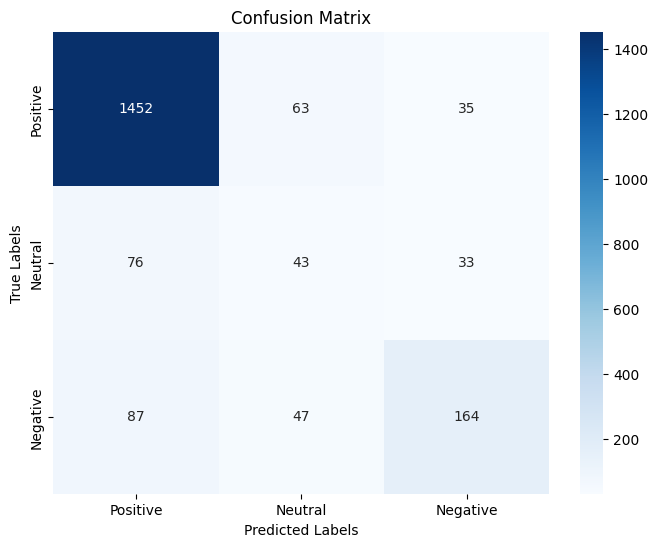

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
